# Quantum Neural Network
Qiskitを使った量子ニューラルネットワーク(QNN)の実装を紹介する。

なお、本notebookの内容はQiskit Documentationの[Machine Learning Tutorials](https://qiskit.org/documentation/machine-learning/tutorials/01_neural_networks.html)の内容を参考にしている。


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer, QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.opflow import StateFn, PauliSumOp, AerPauliExpectation, Gradient
from qiskit.utils import QuantumInstance
from qiskit.algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier

In [2]:
expval = AerPauliExpectation()
gradient = Gradient()
qi_sv = QuantumInstance(Aer.get_backend('statevector_simulator'))
qi_qasm = QuantumInstance(Aer.get_backend('qasm_simulator'), shots=1000)

# QiskitにおけるQNNの実装
QNNの構築の方法は、`NeuralNetwork`というインターフェースをベースに、大きく分けると２種類に分けることが出来る

|クラス名|QNNの出力|
|--|--|
|OpflowQNN (TwoLayerQNN)|オブザーバブルの期待値|
|CircuitQNN|測定によるサンプリング|


## CircuitQNN
The CircuitQNN directly takes the quantum circuit’s measurements as output without an observable. The output can be used either as a batch of samples, i.e., a list of bitstrings measured from the circuit’s qubits, or as a sparse vector of the resulting sampling probabilities for each bitstring. 

In [3]:
from qiskit_machine_learning.neural_networks import CircuitQNN

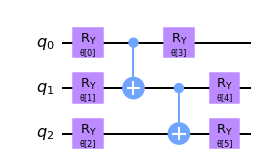

In [4]:
num_qubits = 3
qc = RealAmplitudes(num_qubits, entanglement='linear', reps=1)
qc.draw(output='mpl')

### Output: sparse integer probabilities

In [5]:
# specify circuit QNN
qnn = CircuitQNN(qc, [], qc.parameters, sparse=True, sampling=False, quantum_instance=qi_qasm)

In [6]:
# define (random) input and weights
input = np.random.rand(qnn.num_inputs)
weights = np.random.rand(qnn.num_weights)

In [7]:
# QNN forward pass
# sampling=True: sample
# sampling=False: probability
qnn.forward(input, weights).todense()  # returned as ab sparse matrix

array([[0.558, 0.122, 0.017, 0.007, 0.081, 0.003, 0.002, 0.21 ]])

In [8]:
meas = QuantumCircuit(num_qubits)
meas.measure_all()

qc.assign_parameters(weights, inplace=True)
qc_sampling = meas.compose(qc, front=True) # frontをTrueにしないと測定が先に来てしまう
qi_qasm.execute(qc_sampling).get_counts()

{'000': 559,
 '100': 96,
 '111': 195,
 '010': 23,
 '001': 120,
 '011': 3,
 '110': 3,
 '101': 1}

In [9]:
# QNN backward pass, returns a tuple of sparse matrices
# sampling=True: None
# sampling=False: probability gradient
result = qnn.backward(input, weights)
result[1].todense()

array([[[-0.316 , -0.1545, -0.2405, -0.268 , -0.108 , -0.217 ],
        [ 0.025 ,  0.1275, -0.067 ,  0.275 ,  0.0385, -0.016 ],
        [ 0.01  , -0.0495, -0.0135,  0.0105,  0.0955, -0.009 ],
        [ 0.0255,  0.002 , -0.0395, -0.0145, -0.03  ,  0.0375],
        [-0.034 , -0.088 ,  0.226 , -0.0115, -0.0195,  0.2235],
        [-0.0085,  0.0035,  0.022 ,  0.011 , -0.0145,  0.0175],
        [-0.0285,  0.0615,  0.0085, -0.0185,  0.013 ,  0.0065],
        [ 0.3265,  0.0975,  0.104 ,  0.016 ,  0.025 , -0.043 ]]])

### Output: dense parity probabilities

In [10]:
# specify circuit QNN
parity = lambda x: '{:b}'.format(x).count('1') % 2 # バイナリ表現で1の数/2
output_shape = 2  # this is required in case of a callable with dense output
qnn6 = CircuitQNN(qc, [], qc.parameters, sparse=False, interpret=parity, output_shape=output_shape,
                  quantum_instance=qi_qasm)

In [11]:
# define (random) input and weights
input6 = np.random.rand(qnn6.num_inputs)
weights6 = np.random.rand(qnn6.num_weights)

In [12]:
# QNN forward pass
qnn6.forward(input6, weights6)

array([[0.562, 0.438]])

In [13]:
# QNN backward pass
qnn6.backward(input6, weights6)

(None, None)

## Classification with `CircuitQNN`
`CircuitQNN`は出力としてd次元の確率ベクトルを返す。(dはクラス数)<br>
確率分布で出力が返されるため、得られたビット列から目的のクラスへとマッピングすればよい。

## データの準備
20個のサンプルについて、$y=-x$ を境界として$y>x$の範囲に存在するか、$y<x$の範囲に存在するかを分類する。

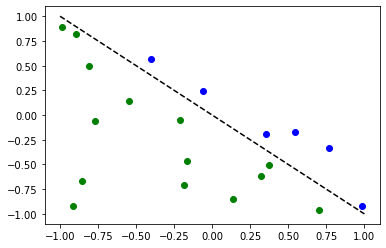

In [14]:
num_inputs = 2
num_samples = 20
X = 2*np.random.rand(num_samples, num_inputs) - 1 # num_sample x num_inpuutsの配列
y01 = 1*(np.sum(X, axis=1) >= 0)  # in { 0,  1}
y = 2*y01-1                       # in {-1, +1}
y_one_hot = np.zeros((num_samples, 2))
for i in range(num_samples):
    y_one_hot[i, y01[i]] = 1

for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
plt.plot([-1, 1], [1, -1], '--', color='black')
plt.show()

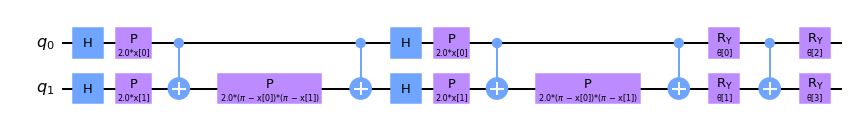

In [15]:
# 量子回路の準備
num_inputs = 2
feature_map = ZZFeatureMap(num_inputs)

ansatz = RealAmplitudes(num_inputs, reps=1)

qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))
qc.decompose().draw(output='mpl')

In [16]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return '{:b}'.format(x).count('1') % 2
output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.

In [17]:
# construct QNN
circuit_qnn = CircuitQNN(circuit=qc,
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=qi_qasm)

In [18]:
# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,
                                             optimizer=COBYLA())

学習させて誤差を評価する

In [19]:
circuit_classifier.fit(X, y01)
circuit_classifier.score(X, y01)

0.8

結果を可視化する。赤い丸で囲われた点は学習後に誤ってラベリングした結果を表している。

In [20]:
# 評価用のデータを生成
num_samples_test = 100
X_test = 2*np.random.rand(num_samples_test, num_inputs) - 1 # num_sample x num_inpuutsの配列
y01_test = 1*(np.sum(X_test, axis=1) >= 0)  # in { 0,  1}
y_test = 2*y01_test-1                       # in {-1, +1}

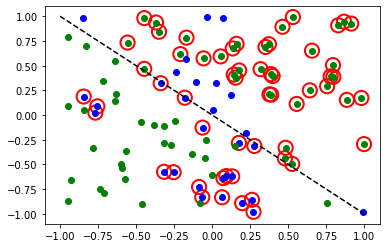

In [21]:
# evaluate data points
y_predict = circuit_classifier.predict(X_test)

# plot results
for x, y_target, y_p in zip(X_test, y01_test, y_predict):
    if y_p == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.plot([-1, 1], [1, -1], '--', color='black')
plt.show()

## reference
1. https://medium.com/qiskit/introducing-qiskit-machine-learning-5f06b6597526

## バージョン情報

In [22]:
import qiskit.tools.jupyter
%qiskit_version_table